In [16]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import multiprocess as mp

In [20]:
## SINGLE-THREAD
## Note: Remember to update both here and inside of solve_system() in cell below

## Note: Remember to update values both here and inside of solve_system() as needed
# k and t domain
k_values = np.linspace(1, 200, 100)  # TODO: replace with the appropriate values
t_span = [0, 20]                     # Time domain

# Initialize an array to store the solutions
times = np.linspace(t_span[0], t_span[1], 500)         # Array of times at which to evaluate
solutions = np.zeros((len(k_values), 2, len(times)))   # Array of solutions for mode k at time t

# Define necessary constants
g     = 0.3      # coupling constant
phi_0 = 1000      # amplitude of inflaton background
m_x   = 0        # mass of photon
m_p   = 1        # mass of inflaton

# Initial conditions
Chi_0 = 0.1; Chidot_0 = 0
y0 = [Chi_0, Chidot_0]

    
# Define the photon field evolution equation
def system(t, y, k):
    dy0dt = y[1]
    dy1dt = -(k**2 + m_x**2)*y[0] - g**2 * phi_0**2 * np.sin(m_p*t)**2 * y[0]
    return [dy0dt, dy1dt]
    
# Solve the differential equation for each k, iteratively
for i, k_i in enumerate(k_values):
    # Solve the differential equation for the given k mode
    sol = solve_ivp(system, t_span, y0, args=(k_i,), dense_output=True)

    # Evaluate the solution at the times in the array
    y = sol.sol(times)

    # Save the solution
    solutions[i] = y
    
    # `solutions[i]` contains the evolution of Chi over time for `k_values[i]`

In [13]:
## PARALLEL
num_cores = 6
parallelize = False  # currently disabled as it does not terminate

## Note: Remember to update values both here and inside of solve_system() as needed
# k values
k_values = np.linspace(1, 200, 50)  # TODO: replace with the appropriate values

# Initialize an array to store the solutions
t_span = [0, 5]                                       # Time domain
times = np.linspace(t_span[0], t_span[1], 500)         # Array of times at which to evaluate
solutions = np.zeros((len(k_values), 2, len(times)))   # Array of solutions for mode k at time t
# Other constants 
m_x = 0

def solve_system(k):
    # Redefine necessary imports and variables (multiprocess bug workaround)
    import numpy as np
    from scipy.integrate import solve_ivp
    
    # Define the photon field evolution equation
    def system(t, y, k):
        dy0dt = y[1]
        dy1dt = -(k**2 + m_x**2)*y[0] - g**2 * phi_0**2 * np.sin(m_p*t)**2 * y[0]
        return [dy0dt, dy1dt]
    
    # Define necessary constants
    g     = 0.3      # coupling constant
    phi_0 = 1e9        # amplitude of inflaton background
    #phi_0 = 1e9      # amplitude of inflaton background
    m_x   = 0        # mass of photon
    m_p   = 1        # mass of inflaton
    Chi_0    = 0.1; Chidot_0 = 0
    y0 = [Chi_0, Chidot_0]    # Initial conditions
    t_span = [0, 20]          # Time domain
    times = np.linspace(t_span[0], t_span[1], 500)         # Array of times at which to evaluate

    # Solve the differential equation for the given k mode
    sol = solve_ivp(system, t_span, y0, args=(k,), dense_output=True)

    # Evaluate the solution at the times in the array
    y = sol.sol(times)

    # Return the solution
    return y


# Solve the differential equation for each k, in parallel
if parallelize:
    with mp.Pool(num_cores) as p:
        solutions = np.array(p.map(solve_system, k_values))
        #solutions = p.starmap(solve_system, [(times, k_i) for k_i in k_values])
    
    # `solutions` contains the solutions for Chi(t) for each k.
    # e.g. `solutions[i]` is the solution for `k_values[i]`.

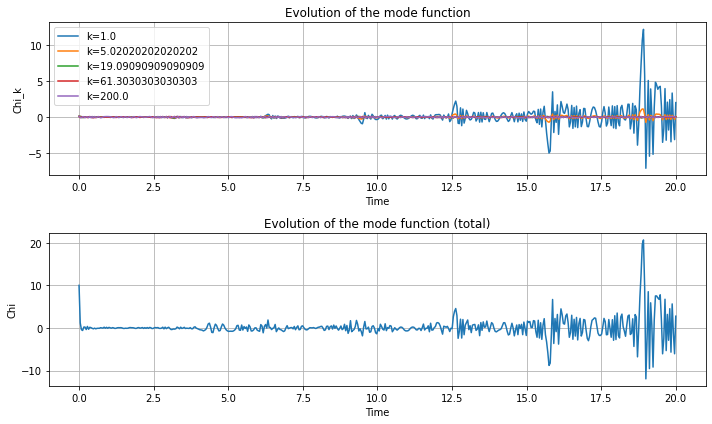

In [21]:
# Plot the solution
k_samples = np.geomspace(1,len(k_values),num=5)
#k_samples = [i for i,k_i in enumerate(k_values) if k_i in [1,50,100,150,200]]
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
for k_sample in k_samples:
    k_s = int(k_sample-1)
    plt.plot(times, solutions[k_s, 0], label='k='+str(k_values[k_s]))
plt.title('Evolution of the mode function')
plt.xlabel('Time')
plt.ylabel('Chi_k')
#plt.yscale('log')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(times, [sum([solutions[i,0,t_i] for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Evolution of the mode function (total)')
plt.xlabel('Time')
plt.ylabel('Chi')
#plt.yscale('log')
plt.grid()

plt.tight_layout()
plt.show()

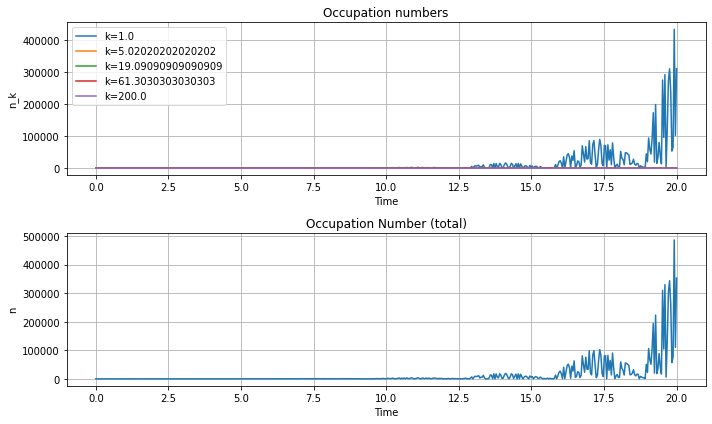

In [22]:
# Plot the occupation numbers
w = lambda i: np.abs(np.sqrt(k_values[i]**2 + m_x**2))
n = lambda i: (w(i)/2) * (((np.abs(solutions[i,1])**2)/(w(i)**2)) + np.abs(solutions[i,0])**2) - (1/2)

k_samples = np.geomspace(1,len(k_values),num=5)
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
for k_sample in k_samples:
    k_s = int(k_sample-1)
    plt.plot(times, n(k_s), label='k='+str(k_values[k_s]))
plt.title('Occupation numbers')
plt.xlabel('Time')
plt.ylabel('n_k')
#plt.yscale('log')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(times, [sum([n(i)[t_i] for i in range(len(k_values))]) for t_i in range(len(times))])
plt.title('Occupation Number (total)')
plt.xlabel('Time')
plt.ylabel('n')
#plt.yscale('log')
plt.grid()

plt.tight_layout()
plt.show()